In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.io import loadmat
from sklearn.metrics import classification_report

In [16]:
#y的label应该是0到9 但是实际上y的label为10 1 2 3 4 5 6 7 8 9 所以将label调整为0-9
def Adjust_label(y):
    idxs=np.flatnonzero(y==10)
    y[idxs]=0
    return y
#展示数据中的数字
def show_data(X,y,num_img_show=5):
    classes=['0','1','2','3','4','5','6','7','8','9']
    cla_len=len(classes)
    for seq,each_class in enumerate(classes):
        idxs=np.flatnonzero(y==int(each_class))
        idxs=np.random.choice(idxs,num_img_show)
        for i,idx in enumerate(idxs):
            plt.subplot(num_img_show,cla_len,i*cla_len+seq+1)
            plt.imshow(X[idx].reshape([20,20]))
            plt.axis('off')
#独热码转换
def onehot_trans(y):
    ret = np.zeros([y.shape[0],10])
    for i,each in enumerate(y):
        ret[i,each]=1
    return ret
def sigmoid(z):
    return 1/(1+np.exp(-z))
#增加常数1
def add_one(X):
    return np.insert(X,0,1,axis=1)
#参数合并
def merge(theta_1,theta_2):
    return np.r_[theta_1.flatten(),theta_2.flatten()]
#参数分离
def divide(theta):
    return theta[:50*401].reshape([401,50]),theta[401*50:].reshape([51,10])
#前向传播
def forward(theta,X,num_hidden=50):
    theta_1,theta_2=divide(theta)
    z2=X@theta_1
    a2=add_one(sigmoid(z2))#有一项偏置项,加上一列1
    z3=a2@theta_2
    a3=sigmoid(z3)#a3即为预测输出y_pred
    return X,z2,a2,z3,a3
# X:m*(n+1) theta:(n+1)*k y:m*k   其中m=5000 n=500 k=10 
def cost(theta,X,y):
    J=0
    a1,z2,a2,z3,h=forward(theta,X)
    for i in range(X.shape[0]):
        J+=np.sum(-y[i]*np.log(h[i])-(1-y[i])*np.log(1-h[i]))
    return J/X.shape[0]
              
def cost_reg(theta,X,y,L):
    theta_1,theta_2=divide(theta)
    reg=np.sum(theta_1[1:,:]**2)+np.sum(theta_2[1:,:]**2)
    return reg*L/(2*X.shape[0])+cost(theta,X,y)
#sigmoid的梯度
def sigmoid_grad(z):
    return sigmoid(z)*(1-sigmoid(z))
#所有参数的梯度
def gradient(theta,X,y):
    a1,z2,a2,z3,y_pre = forward(theta,X)
    theta_1,theta_2=divide(theta)
    delta_3=y_pre-y         #d3:5000*10
    delta_2=delta_3@(theta_2.T[:,1:])*sigmoid_grad(z2)    #5000*10 @ 10*50 * 5000*50 
    D2=a2.T @ delta_3           #51*5000  @ 5000*10
    D1=a1.T @ delta_2           #401*5000 @ 5000*50   
    return 1/X.shape[0]*merge(D1,D2)
#产生-1到1之间的随机数
def gradient_reg(theta,X,y,L):
    D1,D2=divide(gradient(theta,X,y))
    theta_1,theta_2=divide(theta)
    D1_grad=D1 + L/X.shape[0]*theta_1
    D2_grad=D2 + L/X.shape[0]*theta_2
    return merge(D1_grad,D2_grad)
def random_init(size):
    return np.random.uniform(-1, 1, size)
#训练过程
def training_gradient(X, y,max_iter=500,a=0.1,L=1,hidden_layer=50):
    theta=random_init(X.shape[1]*hidden_layer+(hidden_layer+1)*y.shape[1])
    J=np.zeros(max_iter)
    for i in range(max_iter):
        grad=gradient_reg(theta,X,y,L)
        J[i]=cost_reg(theta,X,y,L)
        theta=theta-a*grad
    return theta,J
def accuracy(theta,X,y):
    _,_,_,_,h=forward(theta,X)
    y_pred=np.argmax(h,axis=1).reshape([-1,1])
    print(classification_report(y_pred,y_adj))

In [17]:
data = loadmat("ex4data1.mat")
X = data['X']
y= data['y']
y_adj=Adjust_label(y)
#show_data(X,y_adj)
y=onehot_trans(y_adj)
X=add_one(X)
max_iter=500
theta,J=training_gradient(X,y,max_iter)
accuracy(theta,X,y_adj)



             precision    recall  f1-score   support

          0       0.90      0.85      0.88       528
          1       0.96      0.85      0.90       568
          2       0.82      0.77      0.79       532
          3       0.76      0.78      0.77       486
          4       0.82      0.79      0.80       519
          5       0.60      0.79      0.69       381
          6       0.87      0.83      0.85       522
          7       0.89      0.87      0.88       513
          8       0.74      0.75      0.74       496
          9       0.71      0.78      0.74       455

avg / total       0.82      0.81      0.81      5000



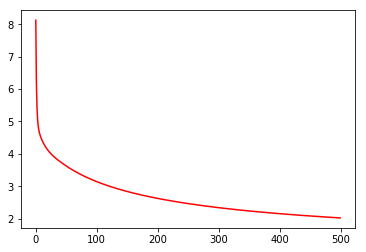

In [18]:
plt.plot(np.arange(max_iter),J,'r-')